In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio

In [2]:
tileid_list = [80607, 80609, 80620]

In [3]:
#some criteria
fail_threshold = 0.0033
deep_dchi2 = 100
mindepth = 120

Tile 80607
13266 1922 6097.749969482422
10388
number, fraction of failures, fraction of failures with zwarn==0
7382 0.0853427255486318 0.057030615009482526
Tile 80609
12750 2125 4106.550003051758
9606
number, fraction of failures, fraction of failures with zwarn==0
6404 0.057932542161149285 0.03513429106808245
Tile 80620
11890 2049 4787.799987792969
8640
number, fraction of failures, fraction of failures with zwarn==0
5670 0.1037037037037037 0.07266313932980599


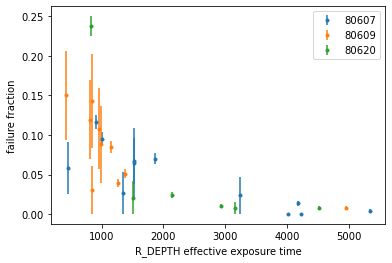

In [5]:
for td in tileid_list:
    
    print('Tile {}'.format(td))
    
    f = fitsio.read('/project/projectdirs/desi/users/ajross/catalogs/SV/redshift_comps/test/'+str(td)+'_LRGzinfo.fits') #fitsio *much* faster than using Table here
    deep = f[f['subset']=='deep'] 
    min_depth = np.max(deep['R_DEPTH'])/2
    print(len(f),len(deep),min_depth)
    
    #get list of truez in appropriate rows, matching Rongpu's definition for criteria required to allow truth determination
    #rows without truth have z==0
    mzl = np.zeros(len(f))
    tids = np.unique(f['TARGETID'])
    for iid in tids:
        sf = f['TARGETID'] == iid
        fi = f[sf]
        fd = fi[fi['subset']=='deep']
        mask = fd['FIBERSTATUS']==0 # Remove FIBERSTATUS!=0 fibers
        mask &= fd['ZWARN'] & 2**9==0 # Remove "no data" fibers
        mask &= fd['ZWARN']==0
        mask &= fd['R_DEPTH'] > min_depth
        mask &= fd['DELTACHI2'] > deep_dchi2
        if len(fd[mask]) > 0:
            mzl[sf] = fd['Z']
    
    w = mzl != 0
    print(len(mzl[w]))
    tf = Table(f)
    tf['Z_TRUTH'] = mzl
    masknight = tf['subset'] != 'deep'
    masknight &= tf['subset'] != 'all'
    masknight &= tf['Z_TRUTH'] != 0
    tcomp = tf[masknight]
    dz = tcomp['Z'] - tcomp['Z_TRUTH']
    bz = abs(dz) > fail_threshold
    bzz = bz & (tcomp['ZWARN'] != 0)
    print('number, fraction of failures, fraction of failures with zwarn==0')
    print(len(tcomp),len(tcomp[bz])/len(tcomp),len(tcomp[bzz])/len(tcomp))
    rvals = np.unique(tcomp['R_DEPTH'])
    ff = []
    rv = []
    nb = []
    nt = []
    for rval in rvals:
        ds = tcomp[tcomp['R_DEPTH']==rval]
        dz = ds['Z'] - ds['Z_TRUTH']
        bz = abs(dz) > fail_threshold
        if len(ds) > 30 and rval > mindepth:
            ff.append(len(ds[bz])/len(ds))
            nb.append(len(ds[bz]))
            nt.append(len(ds))
            rv.append(rval)
    nt = np.array(nt)
    nb = np.array(nb)
    err = ((nt-nb)*(1.-(nt-nb)/nt))**.5/nt #binomial error formula, needs double-check
    plt.errorbar(rv,ff,err,fmt='.',label=td)

plt.legend()
plt.xlabel('R_DEPTH effective exposure time')
plt.ylabel('failure fraction')
plt.show()    
    

    